In [0]:
# imports
import io

import numpy as np
import pandas as pd
from matplotlib import pyplot as plt
from google.colab import files

In [0]:
# parameters
np.random.seed(0) # reproducibility
RANK = 7
MAX_ITERATION = 1000
TOLERANCE = 1e-4
REGULARIZATION_LAMBDA = 1.

In [0]:
# load data
# only need to upload once
#uploaded = files.upload()
#data = pd.read_csv(io.BytesIO(uploaded["allData.tsv"]), sep='\t')
data = pd.read_csv("allData.tsv", sep='\t')

In [0]:
# data properties
print("Columns: ", *data.columns)
print(data[["userID", "movieID", "rating"]].head())
print("Unique users: ", len(data["userID"].unique()))
print("Max user index: ", data["userID"].values.max())
print("Unique movies: ", len(data["movieID"].unique()))
print("Max movie index: ", data["movieID"].values.max())

Columns:  userID age gender movieID name year genre1 genre2 genre3 rating
   userID  movieID  rating
0     747     1193       5
1     747      661       3
2     747     2804       5
3     747      919       4
4     747     2791       4
Unique users:  2353
Max user index:  6038
Unique movies:  1465
Max movie index:  3952


In [0]:
# data normalizaiton

# generate "dense" sparse matrix that contains only relevant entries
look_up_dict = {
  "userID_to_matID": dict(),
  "matID_to_userID": dict(),
  "movieID_to_matID": dict(),
  "matID_to_movieID": dict(),
}

for mid, uid in enumerate(data["userID"].unique()):
  look_up_dict["userID_to_matID"][uid] = mid
  look_up_dict["matID_to_userID"][mid] = uid

for mid, mvid in enumerate(data["movieID"].unique()):
  look_up_dict["movieID_to_matID"][mvid] = mid
  look_up_dict["matID_to_movieID"][mid] = mvid

num_user = len(data["userID"].unique())
num_data = len(data["movieID"].unique())

data_dense = np.zeros([num_user, num_data], dtype=np.float)
data_mask = np.zeros([num_user, num_data], dtype=np.bool)

for idx, entry in data.iterrows():
  uid = entry["userID"]
  mvid = entry["movieID"]
  mat_uid = look_up_dict["userID_to_matID"][uid]
  mat_mvid = look_up_dict["movieID_to_matID"][mvid]
  data_mask[(mat_uid, mat_mvid)] = True
  data_dense[(mat_uid, mat_mvid)] = entry["rating"]

# center entries such that the 1 ~ 5 rating is converted to a -2 ~ 2 system
data_dense[data_mask] -= 3.

# generate held-out data for validation later
# traditional cross validation fail because we do not have a clear distinction
# between features and labels. rather, each data is both a feature and label
# thus to avoid impacting the quality of the model, I will take away only 1% of
# the entries for validation later
validation_mask = (np.random.rand(num_user, num_data) > 0.99) & data_mask
data_mask = data_mask & (~ validation_mask)

In [0]:
# alternating least squares algorithm
# implementing the idea from 
# http://stanford.edu/~rezab/classes/cme323/S15/notes/lec14.pdf

# objective function
def loss(X, Y, Z, mask, lam):
  return np.sum( ((Y.T @ Z - X) ** 2)[mask] ) \
       + lam * np.linalg.norm(Y, ord="fro") \
       + lam * np.linalg.norm(Z, ord="fro")

def approximate(data_dense, data_mask, rank, lam):
  # initialize low-rank approximation matrix as a product of two 
  # Y @ Z = X_bar
  Y = np.random.randn(rank, data_dense.shape[0])
  Z = np.random.randn(rank, data_dense.shape[1])

  # calculation speedup
  lam_I = lam * np.eye(rank)

  # alternating least squares until convergence
  prev_obj = loss(data_dense, Y, Z, data_mask, lam)
  converged = False

  print("Start objective:", prev_obj)

  prev_Y = Y.copy()
  prev_Z = Z.copy()
  for iteration in range(1, MAX_ITERATION + 1):
    if iteration % 10 == 0:
      print("Iteration:", iteration)
      print("Current objective:", prev_obj)
    
    # optimize Y based on current value of Z
    for col in range(Y.shape[1]):
      has_rating = data_mask[col]
      ratings = data_dense[col, has_rating]
      Z_relevant_columns = Z[:, has_rating]
      regularized_cov = np.sum([c.reshape([-1, 1]) @ c.reshape([1, -1]) for
                                c in Z_relevant_columns.T], axis=0) + lam_I
      weighted_sum = np.sum(Z_relevant_columns * ratings, axis=1)
      Y[:, col] = np.linalg.inv(regularized_cov) @ weighted_sum

    # optimize Z based on current values of Y
    for col in range(Z.shape[1]):
      has_rating = data_mask[:, col]
      ratings = data_dense[has_rating, col]
      Y_relevant_columns = Y[:, has_rating]
      regularized_cov = np.sum([c.reshape([-1, 1]) @ c.reshape([1, -1]) for
                                c in Y_relevant_columns.T], axis=0) + lam_I
      weighted_sum = np.sum(Y_relevant_columns * ratings, axis=1)
      Z[:, col] = np.linalg.inv(regularized_cov) @ weighted_sum

    obj = loss(data_dense, Y, Z, data_mask, lam)

    # convergence criteria. prevents division by 0.
    if abs(obj - prev_obj) / ( abs(prev_obj) + 1e-8 ) < TOLERANCE:
      converged = True
      break

    prev_obj = obj

  print("Converged:", converged)
  print("# iterations:", iteration)
  print("Final objective:", obj)

  # report final low-rank matrix
  return Y.T @ Z

In [0]:
# perform low-rank approximation on the entire dataset
# and calculate MSE
data_pred = approximate(data_dense, data_mask, rank=RANK, lam=REGULARIZATION_LAMBDA)

Start objective: 278936.25624390034
Iteration: 10
Current objective: 11854.624864583066
Iteration: 20
Current objective: 11162.197128287302
Iteration: 30
Current objective: 10962.800687566461
Iteration: 40
Current objective: 10872.039892841189
Iteration: 50
Current objective: 10823.800232184605
Iteration: 60
Current objective: 10789.569843940259
Iteration: 70
Current objective: 10764.967265190584
Iteration: 80
Current objective: 10748.686345332097
Iteration: 90
Current objective: 10734.888424570978
Converged: True
# iterations: 99
Final objective: 10721.423766166747


In [0]:
# total squared error divided by the number of entries
absolute_errors = np.abs(data_dense - data_pred)
mad = np.sum(absolute_errors[data_mask]) / np.sum(data_mask)
print("Training MAD:", mad)
mad = np.sum(absolute_errors[validation_mask]) / np.sum(validation_mask)
print("Validation MAD:", mad)
squared_errors = (data_dense - data_pred) ** 2
mse = np.sum(squared_errors[data_mask]) / np.sum(data_mask)
print("Training MSE:", mse)
mse = np.sum(squared_errors[validation_mask]) / np.sum(validation_mask)
print("Validation MSE:", mse)

Training MAD: 0.441216608184267
Validation MAD: 0.868522984461353
Training MSE: 0.3398728835944259
Validation MSE: 1.1815373969047231


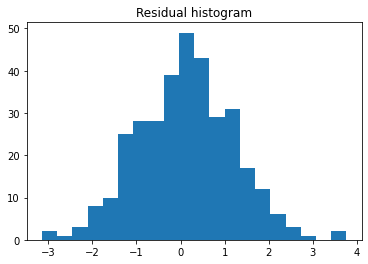

In [0]:
plt.hist((data_dense - data_pred)[validation_mask], bins=20)
plt.title("Residual histogram")
plt.show()